#Seeing Through Multimode fibers
##Tsarantanis Dimitrios - 4479
##Ximerakis Ioannis - 4450

###Mounting Drive###

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


###Setup###

In [2]:
try :
  # In Google Colab
  %tensorflow_version 2.x
except :
  pass

# Import Tensorflow
import tensorflow as tf

# Assure TensorFlow version >= 2 is installed. Otherwise install TensorFlow 2.0 version.
try :
  assert tf.__version__ >= "2.0"
  print ("TensorFlow version found:", tf.__version__)
except :
  !pip install tensorflow==2.0

# Import NumPy and Matplotlib.
import numpy as np
import matplotlib.pyplot as plt

TensorFlow version found: 2.2.0-rc3


In [0]:
import h5py

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import plot_model

##A. Speckle Pattern Classification##

##1. 1km Input Phase##

In [0]:
#Loading speckles from dataset
f = h5py.File('/content/drive/My Drive/fiber data Crete/1km/Input Phase/processed/32_down_input_data.h5', 'r')

In [5]:
f.keys()

<KeysViewHDF5 ['input_data']>

In [0]:
x=f['input_data']

In [7]:
x.shape

(20000, 32, 32, 1)

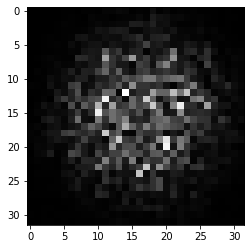

In [8]:
plt.imshow(x[1,:,:,0],cmap='gray')

In [0]:
#Loading labels from dataset
g = h5py.File('/content/drive/My Drive/fiber data Crete/1km/Input Phase/processed/32_down_output_class_onehot.h5', 'r')

In [10]:
list(g.keys())

['output_class_onehot']

In [0]:
y=g['output_class_onehot']

In [12]:
y.shape

(20000, 10)

In [0]:
#Converting data to numpy arrays
x_full=np.array(x)
y_full=np.array(y)
#Splitting to train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_full, y_full, test_size = 0.2, random_state = 42)

In [14]:
y_test.shape

(4000, 10)

In [0]:
#Splitting test set to test and validation
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5, random_state = 42)

In [16]:
print(x_train.shape)
print(x_test.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)

(16000, 32, 32, 1)
(2000, 32, 32, 1)
(2000, 32, 32, 1)
(16000, 10)
(2000, 10)
(2000, 10)


In [17]:
#Classification Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
tf.keras.backend.clear_session


model = Sequential()
model.add(Conv2D(input_shape=(32,32,1),padding="same",filters=32,kernel_size=(3,3), activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=32, activation="relu"))


model.add(Conv2D(kernel_size=(3,3),padding="same",filters=64, activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=64, activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),padding = 'same',strides=(2,2)))

model.add(Conv2D(kernel_size=(3,3),padding="same",filters=128, activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=128, activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),padding = 'same',strides=(2,2)))

model.add(Conv2D(kernel_size=(3,3),padding="same",filters=256, activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=256, activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),padding = 'same',strides=(2,2)))


model.add(Flatten())

model.add(Dropout(0.40)) 
model.add(Dense(256,activation='relu'))

model.add(Dense(10, activation = 'softmax'))

model.summary()

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 20, restore_best_weights = True)

model.compile(loss = "categorical_crossentropy", optimizer = Adam(lr=0.0001), metrics = ["accuracy"])

history = model.fit(x_train, y_train,
                  validation_data = (x_valid, y_valid),
                  epochs = 50, batch_size = 500, callbacks = [early_stopping])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 128)       1

In [18]:
model.evaluate(x_test,y_test)

63/63 [==============================] - 1s 13ms/step - loss: 2.0423 - accuracy: 0.3010


[2.0422871112823486, 0.3009999990463257]

##2. 1km Input Amplitude##

In [0]:
#Loading speckles from dataset
f = h5py.File('/content/drive/My Drive/fiber data Crete/1km/Input Amplitude/processed/32_down_input_data.h5', 'r')


In [20]:
f.keys()

<KeysViewHDF5 ['input_data']>

In [0]:
x=f['input_data']

In [22]:
x.shape

(20000, 32, 32, 1)

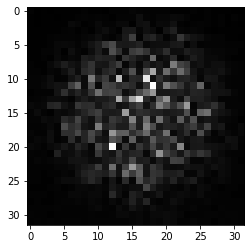

In [23]:
plt.imshow(x[1,:,:,0],cmap='gray')

In [0]:
#Loading labels from dataset
g = h5py.File('/content/drive/My Drive/fiber data Crete/1km/Input Amplitude/processed/32_down_output_class_onehot.h5', 'r')

In [25]:
list(g.keys())

['output_class_onehot']

In [0]:
y=g['output_class_onehot']

In [27]:
y.shape

(20000, 10)

In [0]:
#Converting data to numpy arrays
x_full=np.array(x)
y_full=np.array(y)
#Splitting to train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_full, y_full, test_size = 0.2, random_state = 42)

In [29]:
y_test.shape

(4000, 10)

In [0]:
#Splitting test set to test and validation
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5, random_state = 42)

In [31]:
print(x_train.shape)
print(x_test.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)

(16000, 32, 32, 1)
(2000, 32, 32, 1)
(2000, 32, 32, 1)
(16000, 10)
(2000, 10)
(2000, 10)


In [32]:
#Classification network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
tf.keras.backend.clear_session


model = Sequential()
model.add(Conv2D(input_shape=(32,32,1),padding="same",filters=32,kernel_size=(3,3), activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=32, activation="relu"))


model.add(Conv2D(kernel_size=(3,3),padding="same",filters=64, activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=64, activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),padding = 'same',strides=(2,2)))

model.add(Conv2D(kernel_size=(3,3),padding="same",filters=128, activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=128, activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),padding = 'same',strides=(2,2)))

model.add(Conv2D(kernel_size=(3,3),padding="same",filters=256, activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=256, activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),padding = 'same',strides=(2,2)))


model.add(Flatten())

model.add(Dropout(0.40)) 
model.add(Dense(256,activation='relu'))

model.add(Dense(10, activation = 'softmax'))

model.summary()

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 20, restore_best_weights = True)

model.compile(loss = "categorical_crossentropy", optimizer = Adam(lr=0.0001), metrics = ["accuracy"])

history = model.fit(x_train, y_train,
                  validation_data = (x_valid, y_valid),
                  epochs = 50, batch_size = 500, callbacks = [early_stopping])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 128)      

In [33]:
model.evaluate(x_test,y_test)

63/63 [==============================] - 1s 11ms/step - loss: 1.5826 - accuracy: 0.5020


[1.5825806856155396, 0.5019999742507935]

##3. 10cm Input Phase##

In [0]:
#Loading speckles from dataset
f = h5py.File('/content/drive/My Drive/fiber data Crete/10cm/Input_Phase/processed/32_down_input_processed_data.h5', 'r')


In [35]:
f.keys()

<KeysViewHDF5 ['input_processed_data']>

In [0]:
x=f['input_processed_data']

In [37]:
x.shape

(20000, 32, 32, 1)

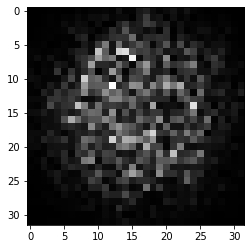

In [38]:
plt.imshow(x[1,:,:,0],cmap='gray')

In [0]:
#Loading labels from dataset
g = h5py.File('/content/drive/My Drive/fiber data Crete/10cm/Input_Phase/processed/32_down_output_class_onehot.h5', 'r')

In [40]:
list(g.keys())

['output_class_onehot']

In [0]:
y=g['output_class_onehot']

In [42]:
y.shape

(20000, 10)

In [0]:
#Converting data to numpy arrays
x_full=np.array(x)
y_full=np.array(y)
#Splitting to train and test set
x_train, x_test, y_train, y_test = train_test_split(x_full, y_full, test_size = 0.2, random_state = 42)

In [44]:
y_test.shape

(4000, 10)

In [0]:
#Splitting test set to test and validation
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5, random_state = 42)

In [46]:
print(x_train.shape)
print(x_test.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)

(16000, 32, 32, 1)
(2000, 32, 32, 1)
(2000, 32, 32, 1)
(16000, 10)
(2000, 10)
(2000, 10)


In [47]:
#Classification network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
tf.keras.backend.clear_session


model = Sequential()
model.add(Conv2D(input_shape=(32,32,1),padding="same",filters=32,kernel_size=(3,3), activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=32, activation="relu"))


model.add(Conv2D(kernel_size=(3,3),padding="same",filters=64, activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=64, activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),padding = 'same',strides=(2,2)))

model.add(Conv2D(kernel_size=(3,3),padding="same",filters=128, activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=128, activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),padding = 'same',strides=(2,2)))

model.add(Conv2D(kernel_size=(3,3),padding="same",filters=256, activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=256, activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),padding = 'same',strides=(2,2)))


model.add(Flatten())

model.add(Dropout(0.40)) 
model.add(Dense(256,activation='relu'))

model.add(Dense(10, activation = 'softmax'))

model.summary()

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 20, restore_best_weights = True)

model.compile(loss = "categorical_crossentropy", optimizer = Adam(lr=0.0001), metrics = ["accuracy"])

history = model.fit(x_train, y_train,
                  validation_data = (x_valid, y_valid),
                  epochs = 50, batch_size = 500, callbacks = [early_stopping])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 128)      

In [48]:
model.evaluate(x_test,y_test)

63/63 [==============================] - 1s 10ms/step - loss: 0.3178 - accuracy: 0.9060


[0.31776589155197144, 0.906000018119812]

##4. 10cm Input Amplitude##

In [0]:
#Loading speckles from dataset
f = h5py.File('/content/drive/My Drive/fiber data Crete/10cm/Input_Amplitude/processed/32_down_input_processed_data.h5', 'r')


In [50]:
f.keys()

<KeysViewHDF5 ['input_processed_data']>

In [0]:
x=f['input_processed_data']

In [52]:
x.shape

(20000, 32, 32, 1)

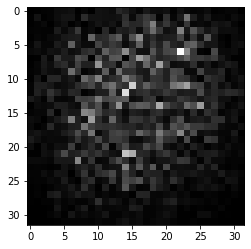

In [53]:
plt.imshow(x[1,:,:,0],cmap='gray')

In [0]:
#Loading labels from dataset
g = h5py.File('/content/drive/My Drive/fiber data Crete/10cm/Input_Amplitude/processed/32_down_output_class_onehot.h5', 'r')

In [55]:
list(g.keys())

['output_class_onehot']

In [0]:
y=g['output_class_onehot']

In [57]:
y.shape

(20000, 10)

In [0]:
#Converting data to numpy arrays
x_full=np.array(x)
y_full=np.array(y)
#Splitting data to train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_full, y_full, test_size = 0.2, random_state = 42)

In [59]:
y_test.shape

(4000, 10)

In [0]:
#Splitting test set to test and validation
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5, random_state = 42)

In [61]:
print(x_train.shape)
print(x_test.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)

(16000, 32, 32, 1)
(2000, 32, 32, 1)
(2000, 32, 32, 1)
(16000, 10)
(2000, 10)
(2000, 10)


In [62]:
#Classification network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
tf.keras.backend.clear_session


model = Sequential()
model.add(Conv2D(input_shape=(32,32,1),padding="same",filters=32,kernel_size=(3,3), activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=32, activation="relu"))


model.add(Conv2D(kernel_size=(3,3),padding="same",filters=64, activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=64, activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),padding = 'same',strides=(2,2)))

model.add(Conv2D(kernel_size=(3,3),padding="same",filters=128, activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=128, activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),padding = 'same',strides=(2,2)))

model.add(Conv2D(kernel_size=(3,3),padding="same",filters=256, activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=256, activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),padding = 'same',strides=(2,2)))


model.add(Flatten())

model.add(Dropout(0.40)) 
model.add(Dense(256,activation='relu'))

model.add(Dense(10, activation = 'softmax'))

model.summary()

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 20, restore_best_weights = True)

model.compile(loss = "categorical_crossentropy", optimizer = Adam(lr=0.0001), metrics = ["accuracy"])

history = model.fit(x_train, y_train,
                  validation_data = (x_valid, y_valid),
                  epochs = 50, batch_size = 500, callbacks = [early_stopping])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 16, 16, 128)      

In [63]:
model.evaluate(x_test,y_test)

63/63 [==============================] - 1s 10ms/step - loss: 0.2584 - accuracy: 0.9235


[0.25844505429267883, 0.9235000014305115]

# B. Reconstruction and Classification #





##1. 1km Input Phase##

In [64]:
#Loading mnist
from keras.datasets import mnist

Using TensorFlow backend.


In [65]:
(x_full_mnist, _), (_, _) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [0]:
x_full_mnist=np.array(x_full_mnist)

In [0]:
#Saving the first 20k images
x_full_mnist=x_full_mnist[:20000]

In [68]:
x_full_mnist.shape

(20000, 28, 28)

In [0]:
#Resizing the images form (28,28) to (32,32,1)
x_full_mnist = resize(x_full_mnist,(20000,32,32,1))

In [70]:
x_full_mnist.shape

(20000, 32, 32, 1)

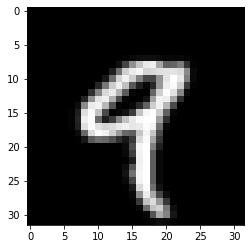

In [71]:
plt.rcParams["axes.grid"] = False
plt.imshow(x_full_mnist[4,:,:,0],cmap='gray')

In [72]:
#Loading speckles from dataset
X = h5py.File('/content/drive/My Drive/fiber data Crete/1km/Input Phase/processed/32_down_input_data.h5', 'r')
list(X.keys())

['input_data']

In [0]:
#Converting speckles to numpy array
X=X['input_data']
X_full=np.array(X)


In [74]:
print(X_full.shape)
print(x_full_mnist.shape)

(20000, 32, 32, 1)
(20000, 32, 32, 1)


In [0]:
#Splitting data to train and test sets
x_train, x_test, x_train_mnist, x_test_mnist = train_test_split(X_full, x_full_mnist, test_size = 0.2, random_state = 42)


In [0]:
#Splitting test set to test and validation sets
x_test, x_valid, x_test_mnist, x_valid_mnist = train_test_split(x_test, x_test_mnist, test_size = 0.5, random_state = 42)

In [0]:
#Now the images are split in the same way as earlier, so the 2k images of the test set are the same and will not be used when training the u-net
#Combining validation and train sets into one training set (Since we won't be using a validation set when training the u-net)
x_train=np.concatenate((x_train,x_valid))
x_train_mnist=np.concatenate((x_train_mnist,x_valid_mnist))

In [78]:
print(x_train.shape)
print(x_test.shape)
#print(x_valid.shape)
print(x_train_mnist.shape)
print(x_test_mnist.shape)
#print(y_valid.shape)

(18000, 32, 32, 1)
(2000, 32, 32, 1)
(18000, 32, 32, 1)
(2000, 32, 32, 1)


In [0]:
#U-net
tf.keras.backend.clear_session
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
     #first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [0]:
def get_unet(input_img, n_filters=32, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((1, 1)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    ##

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (p4)
    u7 = concatenate([u7, p3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, p2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, p1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [81]:
input_img = Input((32, 32, 1), name='img')
model = get_unet(input_img, n_filters=32, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(lr=0.0004), loss="binary_crossentropy")
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 32, 32, 32)   320         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d_32[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [82]:
history = model.fit(x_train, x_train_mnist,
                  
                  epochs = 35, batch_size = 50)

Epoch 1/35
360/360 [==============================] - 27s 76ms/step - loss: 0.3498
Epoch 2/35
360/360 [==============================] - 27s 76ms/step - loss: 0.2736
Epoch 3/35
360/360 [==============================] - 27s 76ms/step - loss: 0.2670
Epoch 4/35
360/360 [==============================] - 27s 76ms/step - loss: 0.2639
Epoch 5/35
360/360 [==============================] - 27s 76ms/step - loss: 0.2616
Epoch 6/35
360/360 [==============================] - 27s 76ms/step - loss: 0.2592
Epoch 7/35
360/360 [==============================] - 27s 76ms/step - loss: 0.2561
Epoch 8/35
360/360 [==============================] - 27s 76ms/step - loss: 0.2532
Epoch 9/35
360/360 [==============================] - 27s 76ms/step - loss: 0.2497
Epoch 10/35
360/360 [==============================] - 27s 76ms/step - loss: 0.2454
Epoch 11/35
360/360 [==============================] - 27s 76ms/step - loss: 0.2407
Epoch 12/35
360/360 [==============================] - 27s 76ms/step - loss: 0.2363
E

In [0]:
#Reconstructing all 20k images
recon=np.array(model.predict(X_full))

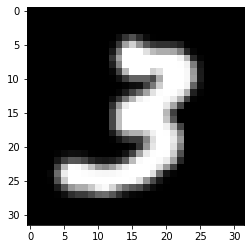

In [84]:
#Plotting original image
from matplotlib import pyplot as plt
plt.rcParams["axes.grid"] = False
plt.imshow(x_full_mnist[12100,:,:,0],cmap='gray')

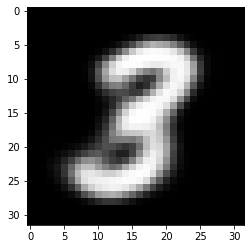

In [85]:
#Plotting reconstructed image
plt.imshow(recon[12100,:,:,0],cmap='gray')

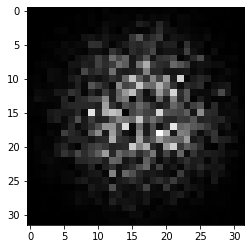

In [86]:
#Plotting the speckle 
plt.imshow(X_full[12100,:,:,0],cmap='gray')

In [0]:
#Loading labels
y =  h5py.File('/content/drive/My Drive/fiber data Crete/1km/Input Phase/processed/32_down_output_class_onehot.h5', 'r')

In [88]:
list(y.keys())

['output_class_onehot']

In [0]:
y=y['output_class_onehot']

In [0]:
y=np.array(y)

In [91]:
y.shape

(20000, 10)

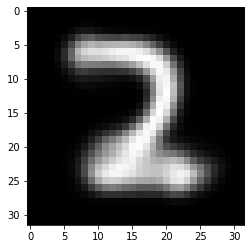

In [92]:
plt.imshow(recon[19999,:,:,0],cmap='gray')

In [93]:
y[19999]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [0]:
#Splitting data to train and test sets
recon_train, recon_test, y_train, y_test = train_test_split(recon, y, test_size = 0.1, random_state = 42)

In [0]:
#Splitting the test set to test and validation sets
recon_train, recon_valid, y_train, y_valid = train_test_split(recon_train, y_train, test_size = 2000, random_state = 42)

In [96]:
print(recon_train.shape)
print(recon_test.shape)
print(recon_valid.shape)
print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)

(16000, 32, 32, 1)
(2000, 32, 32, 1)
(2000, 32, 32, 1)
(16000, 10)
(2000, 10)
(2000, 10)


In [97]:
#Classification network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
tf.keras.backend.clear_session


model = Sequential()
model.add(Conv2D(input_shape=(32,32,1),padding="same",filters=32,kernel_size=(3,3), activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=32, activation="relu"))





model.add(Conv2D(kernel_size=(3,3),padding="same",filters=64, activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=64, activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),padding = 'same',strides=(2,2)))



model.add(Conv2D(kernel_size=(3,3),padding="same",filters=128, activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=128, activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),padding = 'same',strides=(2,2)))



model.add(Conv2D(kernel_size=(3,3),padding="same",filters=256, activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=256, activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),padding = 'same',strides=(2,2)))




model.add(Flatten())

model.add(Dropout(0.4)) 
model.add(Dense(256,activation='relu'))

model.add(Dense(10, activation = 'softmax'))

model.summary()

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 20, restore_best_weights = True)

model.compile(loss = "categorical_crossentropy", optimizer = Adam(lr=0.0001), metrics = ["accuracy"])
history = model.fit(recon_train, y_train,
                  validation_data = (recon_valid, y_valid),
                  epochs = 50, batch_size = 500, callbacks = [early_stopping])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 16, 16, 128)      

In [98]:
model.evaluate(recon_test,y_test)

63/63 [==============================] - 1s 11ms/step - loss: 1.1703 - accuracy: 0.6720


[1.1703037023544312, 0.671999990940094]

##2. 1km Input Amplitude##

In [0]:
#Loading mnist
from keras.datasets import mnist

In [0]:
(x_full_mnist, _), (_, _) = mnist.load_data()

In [0]:
x_full_mnist=np.array(x_full_mnist)

In [0]:
#Saving the first 20k images
x_full_mnist=x_full_mnist[:20000]

In [103]:
x_full_mnist.shape

(20000, 28, 28)

In [0]:
#Resizing the images form (28,28) to (32,32,1)
x_full_mnist = resize(x_full_mnist,(20000,32,32,1))

In [105]:
x_full_mnist.shape

(20000, 32, 32, 1)

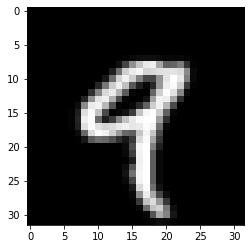

In [106]:
plt.rcParams["axes.grid"] = False
plt.imshow(x_full_mnist[4,:,:,0],cmap='gray')

In [107]:
#Loading speckles from dataset
X = h5py.File('/content/drive/My Drive/fiber data Crete/1km/Input Amplitude/processed/32_down_input_data.h5', 'r')
list(X.keys())

['input_data']

In [0]:
X=X['input_data']
X_full=np.array(X)


In [109]:
print(X_full.shape)
print(x_full_mnist.shape)

(20000, 32, 32, 1)
(20000, 32, 32, 1)


In [0]:
#Splitting data to train and test sets
x_train, x_test, x_train_mnist, x_test_mnist = train_test_split(X_full, x_full_mnist, test_size = 0.2, random_state = 42)


In [0]:
#Splitting test set to test and validation sets
x_test, x_valid, x_test_mnist, x_valid_mnist = train_test_split(x_test, x_test_mnist, test_size = 0.5, random_state = 42)

In [0]:
#Now the images are split in the same way as earlier, so the 2k images of the test set are the same and will not be used when training the u-net
#Combining validation and train sets into one training set (Since we won't be using a validation set when training the u-net)
x_train=np.concatenate((x_train,x_valid))
x_train_mnist=np.concatenate((x_train_mnist,x_valid_mnist))

In [113]:
print(x_train.shape)
print(x_test.shape)
#print(x_valid.shape)
print(x_train_mnist.shape)
print(x_test_mnist.shape)
#print(y_valid.shape)

(18000, 32, 32, 1)
(2000, 32, 32, 1)
(18000, 32, 32, 1)
(2000, 32, 32, 1)


In [0]:
#U-net
tf.keras.backend.clear_session
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
     #first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [0]:
def get_unet(input_img, n_filters=32, dropout=0.5, batchnorm=True):
    
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((1, 1)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    ##

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (p4)
    u7 = concatenate([u7, p3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, p2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, p1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [116]:
input_img = Input((32, 32, 1), name='img')
model = get_unet(input_img, n_filters=32, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(lr=0.0004), loss="binary_crossentropy")
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 32, 32, 32)   320         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 32, 32, 32)   128         conv2d_55[0][0]                  
__________________________________________________________________________________________________
activation_14 (Activation)      (None, 32, 32, 32)   0           batch_normalization_14[0][0]     
____________________________________________________________________________________________

In [117]:
history = model.fit(x_train, x_train_mnist,
                  
                  epochs = 35, batch_size = 50)

Epoch 1/35
360/360 [==============================] - 27s 76ms/step - loss: 0.2874
Epoch 2/35
360/360 [==============================] - 27s 75ms/step - loss: 0.2534
Epoch 3/35
360/360 [==============================] - 27s 76ms/step - loss: 0.2487
Epoch 4/35
360/360 [==============================] - 27s 76ms/step - loss: 0.2430
Epoch 5/35
360/360 [==============================] - 27s 76ms/step - loss: 0.2358
Epoch 6/35
360/360 [==============================] - 27s 76ms/step - loss: 0.2280
Epoch 7/35
360/360 [==============================] - 27s 75ms/step - loss: 0.2208
Epoch 8/35
360/360 [==============================] - 27s 75ms/step - loss: 0.2140
Epoch 9/35
360/360 [==============================] - 27s 75ms/step - loss: 0.2079
Epoch 10/35
360/360 [==============================] - 27s 76ms/step - loss: 0.2019
Epoch 11/35
360/360 [==============================] - 27s 75ms/step - loss: 0.1971
Epoch 12/35
360/360 [==============================] - 27s 75ms/step - loss: 0.1923
E

In [0]:
#Reconstructing all 20k images
recon=np.array(model.predict(X_full))

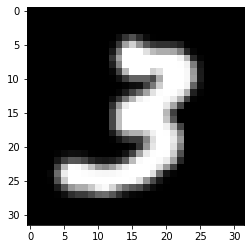

In [119]:
#Plotting original image
from matplotlib import pyplot as plt
plt.rcParams["axes.grid"] = False
plt.imshow(x_full_mnist[12100,:,:,0],cmap='gray')

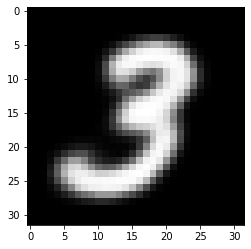

In [120]:
#Plotting reconstructed image
plt.imshow(recon[12100,:,:,0],cmap='gray')

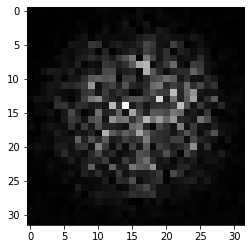

In [121]:
#Plotting the speckle 
plt.imshow(X_full[12100,:,:,0],cmap='gray')

In [0]:
#Loading labels
y =  h5py.File('/content/drive/My Drive/fiber data Crete/1km/Input Amplitude/processed/32_down_output_class_onehot.h5', 'r')

In [123]:
list(y.keys())

['output_class_onehot']

In [0]:
y=y['output_class_onehot']

In [0]:
y=np.array(y)

In [126]:
y.shape

(20000, 10)

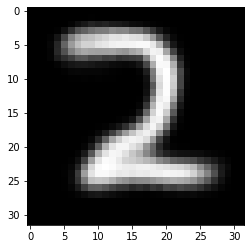

In [127]:
plt.imshow(recon[19999,:,:,0],cmap='gray')

In [128]:
y[19999]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [0]:
#Splitting data to train and test sets
recon_train, recon_test, y_train, y_test = train_test_split(recon, y, test_size = 0.1, random_state = 42)

In [0]:
#Splitting the test set to test and validation sets
recon_train, recon_valid, y_train, y_valid = train_test_split(recon_train, y_train, test_size = 2000, random_state = 42)

In [131]:
print(recon_train.shape)
print(recon_test.shape)
print(recon_valid.shape)
print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)

(16000, 32, 32, 1)
(2000, 32, 32, 1)
(2000, 32, 32, 1)
(16000, 10)
(2000, 10)
(2000, 10)


In [132]:
#Classification network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
tf.keras.backend.clear_session


model = Sequential()
model.add(Conv2D(input_shape=(32,32,1),padding="same",filters=32,kernel_size=(3,3), activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=32, activation="relu"))





model.add(Conv2D(kernel_size=(3,3),padding="same",filters=64, activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=64, activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),padding = 'same',strides=(2,2)))



model.add(Conv2D(kernel_size=(3,3),padding="same",filters=128, activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=128, activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),padding = 'same',strides=(2,2)))



model.add(Conv2D(kernel_size=(3,3),padding="same",filters=256, activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=256, activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),padding = 'same',strides=(2,2)))




model.add(Flatten())

model.add(Dropout(0.4)) 
model.add(Dense(256,activation='relu'))

model.add(Dense(10, activation = 'softmax'))

model.summary()

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 20, restore_best_weights = True)

model.compile(loss = "categorical_crossentropy", optimizer = Adam(lr=0.0001), metrics = ["accuracy"])
history = model.fit(recon_train, y_train,
                  validation_data = (recon_valid, y_valid),
                  epochs = 50, batch_size = 500, callbacks = [early_stopping])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 16, 16, 128)      

In [133]:
model.evaluate(recon_test,y_test)

63/63 [==============================] - 1s 10ms/step - loss: 0.8515 - accuracy: 0.7895


[0.8515302538871765, 0.7894999980926514]

##3. 10cm Input Phase##

In [0]:
#Loading mnist
(x_full_mnist, _), (_, _) = mnist.load_data()

In [0]:
x_full_mnist=np.array(x_full_mnist)

In [0]:
#Saving the first 20k images
x_full_mnist=x_full_mnist[:20000]

In [137]:
x_full_mnist.shape

(20000, 28, 28)

In [0]:
#Resizing the images form (28,28) to (32,32,1)
x_full_mnist = resize(x_full_mnist,(20000,32,32,1))

In [139]:
x_full_mnist.shape

(20000, 32, 32, 1)

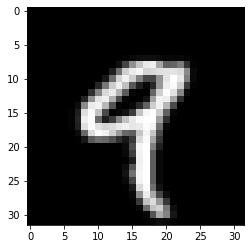

In [140]:
plt.rcParams["axes.grid"] = False
plt.imshow(x_full_mnist[4,:,:,0],cmap='gray')

In [141]:
#Loading speckles from dataset
X = h5py.File('/content/drive/My Drive/fiber data Crete/10cm/Input_Phase/processed/32_down_input_processed_data.h5', 'r')
list(X.keys())

['input_processed_data']

In [0]:
X=X['input_processed_data']
X_full=np.array(X)


In [143]:
print(X_full.shape)
print(x_full_mnist.shape)

(20000, 32, 32, 1)
(20000, 32, 32, 1)


In [0]:
#Splitting data to train and test sets
x_train, x_test, x_train_mnist, x_test_mnist = train_test_split(X_full, x_full_mnist, test_size = 0.2, random_state = 42)


In [0]:
#Splitting test set to test and validation sets
x_test, x_valid, x_test_mnist, x_valid_mnist = train_test_split(x_test, x_test_mnist, test_size = 0.5, random_state = 42)

In [0]:
#Now the images are split in the same way as earlier, so the 2k images of the test set are the same and will not be used when training the u-net
#Combining validation and train sets into one training set (Since we won't be using a validation set when training the u-net)
x_train=np.concatenate((x_train,x_valid))
x_train_mnist=np.concatenate((x_train_mnist,x_valid_mnist))

In [147]:
print(x_train.shape)
print(x_test.shape)
#print(x_valid.shape)
print(x_train_mnist.shape)
print(x_test_mnist.shape)
#print(y_valid.shape)

(18000, 32, 32, 1)
(2000, 32, 32, 1)
(18000, 32, 32, 1)
(2000, 32, 32, 1)


In [0]:
#U-net
tf.keras.backend.clear_session
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
     #first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [0]:
def get_unet(input_img, n_filters=32, dropout=0.5, batchnorm=True):
    
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((1, 1)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    ##

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (p4)
    u7 = concatenate([u7, p3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, p2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, p1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [150]:
input_img = Input((32, 32, 1), name='img')
model = get_unet(input_img, n_filters=32, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(lr=0.0004), loss="binary_crossentropy")
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 32, 32, 32)   320         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 32, 32, 32)   128         conv2d_78[0][0]                  
__________________________________________________________________________________________________
activation_28 (Activation)      (None, 32, 32, 32)   0           batch_normalization_28[0][0]     
____________________________________________________________________________________________

In [151]:
history = model.fit(x_train, x_train_mnist,
                  
                  epochs = 35, batch_size = 50)

Epoch 1/35
360/360 [==============================] - 27s 76ms/step - loss: 0.2374
Epoch 2/35
360/360 [==============================] - 27s 76ms/step - loss: 0.1650
Epoch 3/35
360/360 [==============================] - 27s 76ms/step - loss: 0.1484
Epoch 4/35
360/360 [==============================] - 27s 76ms/step - loss: 0.1401
Epoch 5/35
360/360 [==============================] - 27s 76ms/step - loss: 0.1346
Epoch 6/35
360/360 [==============================] - 27s 76ms/step - loss: 0.1310
Epoch 7/35
360/360 [==============================] - 27s 76ms/step - loss: 0.1281
Epoch 8/35
360/360 [==============================] - 27s 76ms/step - loss: 0.1258
Epoch 9/35
360/360 [==============================] - 27s 76ms/step - loss: 0.1239
Epoch 10/35
360/360 [==============================] - 27s 76ms/step - loss: 0.1225
Epoch 11/35
360/360 [==============================] - 27s 76ms/step - loss: 0.1211
Epoch 12/35
360/360 [==============================] - 27s 76ms/step - loss: 0.1199
E

In [0]:
#Reconstructing all 20k images
recon=np.array(model.predict(X_full))

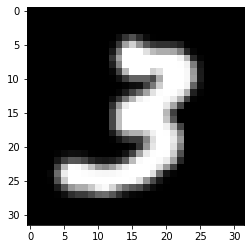

In [153]:
#Plotting original image
from matplotlib import pyplot as plt
plt.rcParams["axes.grid"] = False
plt.imshow(x_full_mnist[12100,:,:,0],cmap='gray')

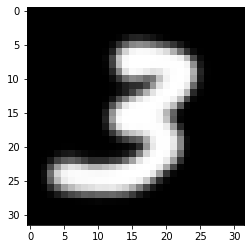

In [154]:
#Plotting reconstructed image
plt.imshow(recon[12100,:,:,0],cmap='gray')

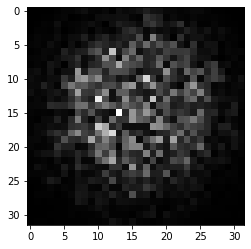

In [155]:
#Plotting the speckle 
plt.imshow(X_full[12100,:,:,0],cmap='gray')

In [0]:
#Loading labels
y =  h5py.File('/content/drive/My Drive/fiber data Crete/10cm/Input_Phase/processed/32_down_output_class_onehot.h5', 'r')

In [157]:
list(y.keys())

['output_class_onehot']

In [0]:
y=y['output_class_onehot']

In [0]:
y=np.array(y)

In [160]:
y.shape

(20000, 10)

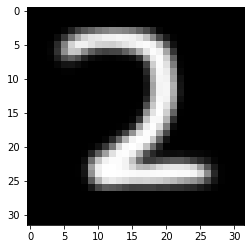

In [161]:
plt.imshow(recon[19999,:,:,0],cmap='gray')

In [162]:
y[19999]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [0]:
#Splitting data to train and test sets
recon_train, recon_test, y_train, y_test = train_test_split(recon, y, test_size = 0.1, random_state = 42)

In [0]:
#Splitting the test set to test and validation sets
recon_train, recon_valid, y_train, y_valid = train_test_split(recon_train, y_train, test_size = 2000, random_state = 42)

In [165]:
print(recon_train.shape)
print(recon_test.shape)
print(recon_valid.shape)
print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)

(16000, 32, 32, 1)
(2000, 32, 32, 1)
(2000, 32, 32, 1)
(16000, 10)
(2000, 10)
(2000, 10)


In [166]:
#Classification network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
tf.keras.backend.clear_session


model = Sequential()
model.add(Conv2D(input_shape=(32,32,1),padding="same",filters=32,kernel_size=(3,3), activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=32, activation="relu"))





model.add(Conv2D(kernel_size=(3,3),padding="same",filters=64, activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=64, activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),padding = 'same',strides=(2,2)))



model.add(Conv2D(kernel_size=(3,3),padding="same",filters=128, activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=128, activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),padding = 'same',strides=(2,2)))



model.add(Conv2D(kernel_size=(3,3),padding="same",filters=256, activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=256, activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),padding = 'same',strides=(2,2)))




model.add(Flatten())

model.add(Dropout(0.4)) 
model.add(Dense(256,activation='relu'))

model.add(Dense(10, activation = 'softmax'))

model.summary()

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 20, restore_best_weights = True)

model.compile(loss = "categorical_crossentropy", optimizer = Adam(lr=0.0001), metrics = ["accuracy"])
history = model.fit(recon_train, y_train,
                  validation_data = (recon_valid, y_valid),
                  epochs = 50, batch_size = 500, callbacks = [early_stopping])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_93 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 16, 16, 128)      

In [167]:
model.evaluate(recon_test,y_test)

63/63 [==============================] - 1s 10ms/step - loss: 0.0901 - accuracy: 0.9730


[0.09011070430278778, 0.9729999899864197]

##4. 10cm Input Amplitude##

In [0]:
#Loading mnist
(x_full_mnist, _), (_, _) = mnist.load_data()

In [0]:
x_full_mnist=np.array(x_full_mnist)

In [0]:
#Saving the first 20k images
x_full_mnist=x_full_mnist[:20000]

In [171]:
x_full_mnist.shape

(20000, 28, 28)

In [0]:
#Resizing the images form (28,28) to (32,32,1)
x_full_mnist = resize(x_full_mnist,(20000,32,32,1))

In [173]:
x_full_mnist.shape

(20000, 32, 32, 1)

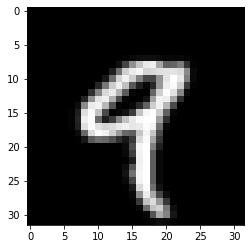

In [174]:
plt.rcParams["axes.grid"] = False
plt.imshow(x_full_mnist[4,:,:,0],cmap='gray')

In [175]:
#Loading speckles from dataset
X = h5py.File('/content/drive/My Drive/fiber data Crete/10cm/Input_Amplitude/processed/32_down_input_processed_data.h5', 'r')
list(X.keys())

['input_processed_data']

In [0]:
X=X['input_processed_data']
X_full=np.array(X)


In [177]:
print(X_full.shape)
print(x_full_mnist.shape)

(20000, 32, 32, 1)
(20000, 32, 32, 1)


In [0]:
#Splitting data to train and test sets
x_train, x_test, x_train_mnist, x_test_mnist = train_test_split(X_full, x_full_mnist, test_size = 0.2, random_state = 42)


In [0]:
#Splitting test set to test and validation sets
x_test, x_valid, x_test_mnist, x_valid_mnist = train_test_split(x_test, x_test_mnist, test_size = 0.5, random_state = 42)

In [0]:
#Now the images are split in the same way as earlier, so the 2k images of the test set are the same and will not be used when training the u-net
#Combining validation and train sets into one training set (Since we won't be using a validation set when training the u-net)
x_train=np.concatenate((x_train,x_valid))
x_train_mnist=np.concatenate((x_train_mnist,x_valid_mnist))

In [181]:
print(x_train.shape)
print(x_test.shape)
#print(x_valid.shape)
print(x_train_mnist.shape)
print(x_test_mnist.shape)
#print(y_valid.shape)

(18000, 32, 32, 1)
(2000, 32, 32, 1)
(18000, 32, 32, 1)
(2000, 32, 32, 1)


In [0]:
#U-net
tf.keras.backend.clear_session
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
     #first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [0]:
def get_unet(input_img, n_filters=32, dropout=0.5, batchnorm=True):
    
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((1, 1)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    ##

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (p4)
    u7 = concatenate([u7, p3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, p2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, p1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [184]:
input_img = Input((32, 32, 1), name='img')
model = get_unet(input_img, n_filters=32, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(lr=0.0004), loss="binary_crossentropy")
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_101 (Conv2D)             (None, 32, 32, 32)   320         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 32, 32, 32)   128         conv2d_101[0][0]                 
__________________________________________________________________________________________________
activation_42 (Activation)      (None, 32, 32, 32)   0           batch_normalization_42[0][0]     
____________________________________________________________________________________________

In [185]:
history = model.fit(x_train, x_train_mnist, 
                  
                  epochs = 35, batch_size = 50)

Epoch 1/35
360/360 [==============================] - 27s 76ms/step - loss: 0.2957
Epoch 2/35
360/360 [==============================] - 27s 75ms/step - loss: 0.1676
Epoch 3/35
360/360 [==============================] - 27s 75ms/step - loss: 0.1455
Epoch 4/35
360/360 [==============================] - 27s 76ms/step - loss: 0.1358
Epoch 5/35
360/360 [==============================] - 27s 75ms/step - loss: 0.1301
Epoch 6/35
360/360 [==============================] - 27s 76ms/step - loss: 0.1265
Epoch 7/35
360/360 [==============================] - 27s 75ms/step - loss: 0.1237
Epoch 8/35
360/360 [==============================] - 27s 75ms/step - loss: 0.1217
Epoch 9/35
360/360 [==============================] - 27s 75ms/step - loss: 0.1201
Epoch 10/35
360/360 [==============================] - 27s 75ms/step - loss: 0.1187
Epoch 11/35
360/360 [==============================] - 27s 75ms/step - loss: 0.1176
Epoch 12/35
360/360 [==============================] - 27s 75ms/step - loss: 0.1164
E

In [0]:
#Reconstructing all 20k images
recon=np.array(model.predict(X_full))

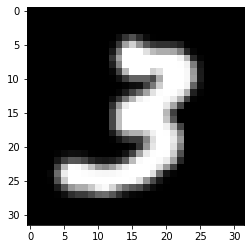

In [187]:
#Plotting original image
from matplotlib import pyplot as plt
plt.rcParams["axes.grid"] = False
plt.imshow(x_full_mnist[12100,:,:,0],cmap='gray')

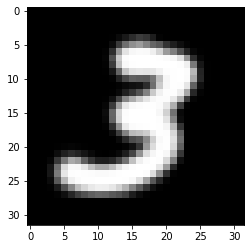

In [188]:
#Plotting reconstructed image
plt.imshow(recon[12100,:,:,0],cmap='gray')

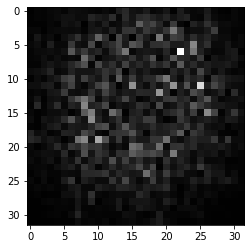

In [189]:
#Plotting the speckle 
plt.imshow(X_full[12100,:,:,0],cmap='gray')

In [0]:
#Loading labels
y =  h5py.File('/content/drive/My Drive/fiber data Crete/10cm/Input_Amplitude/processed/32_down_output_class_onehot.h5', 'r')

In [191]:
list(y.keys())

['output_class_onehot']

In [0]:
y=y['output_class_onehot']

In [0]:
y=np.array(y)

In [194]:
y.shape

(20000, 10)

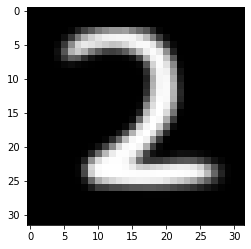

In [195]:
plt.imshow(recon[19999,:,:,0],cmap='gray')

In [196]:
y[19999]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [0]:
#Splitting data to train and test sets
recon_train, recon_test, y_train, y_test = train_test_split(recon, y, test_size = 0.1, random_state = 42)

In [0]:
#Splitting the test set to test and validation sets
recon_train, recon_valid, y_train, y_valid = train_test_split(recon_train, y_train, test_size = 2000, random_state = 42)

In [199]:
print(recon_train.shape)
print(recon_test.shape)
print(recon_valid.shape)
print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)

(16000, 32, 32, 1)
(2000, 32, 32, 1)
(2000, 32, 32, 1)
(16000, 10)
(2000, 10)
(2000, 10)


In [200]:
#Classification network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
tf.keras.backend.clear_session


model = Sequential()
model.add(Conv2D(input_shape=(32,32,1),padding="same",filters=32,kernel_size=(3,3), activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=32, activation="relu"))





model.add(Conv2D(kernel_size=(3,3),padding="same",filters=64, activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=64, activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),padding = 'same',strides=(2,2)))



model.add(Conv2D(kernel_size=(3,3),padding="same",filters=128, activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=128, activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),padding = 'same',strides=(2,2)))



model.add(Conv2D(kernel_size=(3,3),padding="same",filters=256, activation="relu"))
model.add(Conv2D(kernel_size=(3,3),padding="same",filters=256, activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),padding = 'same',strides=(2,2)))




model.add(Flatten())

model.add(Dropout(0.4)) 
model.add(Dense(256,activation='relu'))

model.add(Dense(10, activation = 'softmax'))

model.summary()

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 20, restore_best_weights = True)

model.compile(loss = "categorical_crossentropy", optimizer = Adam(lr=0.0001), metrics = ["accuracy"])
history = model.fit(recon_train, y_train,
                  validation_data = (recon_valid, y_valid),
                  epochs = 50, batch_size = 500, callbacks = [early_stopping])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_116 (Conv2D)          (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 16, 16, 128)      

In [201]:
model.evaluate(recon_test,y_test)

63/63 [==============================] - 1s 11ms/step - loss: 0.0824 - accuracy: 0.9780


[0.08235787600278854, 0.9779999852180481]